# Regression Decision Tree 

## Import Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

## Importing data

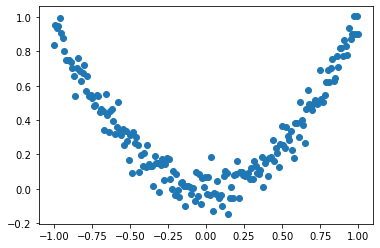

In [3]:
# First tried with the parabola, but had issues in the concatenate inside the fit
N = 200
X = np.linspace(-1,1,N)
Y = X**2 + np.random.normal(0, 0.07, N)
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
plt.scatter(X,Y)
plt.show()


In [4]:
#flattened_X = [i for j in X for i in j]
#X = np.array(flattened_X)

In [5]:
#from sklearn.datasets import load_diabetes

#diabetes = load_diabetes()

## Node class

A small class just containing a constructor, which will basically describe the nodes of our tree. 

In [6]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # Decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

## Tree class

The actual algorithm, which will contain a tree building part, entropy calculation etc.

In [7]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        
        # extracts the number of samples and features 
        num_samples, num_features = np.shape(X)
        best_split = {}
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            # check if information gain is positive
            if best_split["var_red"]>0:
                
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split 
        returns a dictionary, indeed best_split dicsionary is defined at the beginning and max info gain is initializeed 
        as negatve infinity, since we want to maximise the information gain, and to find that we need to use a  number
        bigger that any other number '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        ''' function to compute variance reduction '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node.
        
        For regression, leaf node is computed by the mean of the values in the predictor column, while
        for classificaiton, the leaf node is computed by majority rule.
        
        '''
        
        val = np.mean(Y) # mean class contained in that particular node 
        return val
                
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
            
            
            
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        # concatenate x and y to create the dataset
        
        #dataset = np.concatenate((X, Y), axis=1)
        #dataset = np.column_stack((X,Y))
        dataset = np.hstack((X,Y))
        
        
        # call the build tree function
        #root node will be returned by the build tree fct and it will be stored in self.root
        
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

## Train-Test split

In [8]:
#X = data.iloc[:, :-1].values
#Y = data.iloc[:, -1].values.reshape(-1,1)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

#X_train, X_test, Y_train, Y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.3, random_state=0)

In [9]:
X_train.ndim

2

In [10]:
Y_train.ndim

2

## Fit the model

In [11]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(X_train,Y_train)
regressor.print_tree()

X_0 <= -0.7185929648241206 ? 0.028045430742468125
 left:X_0 <= -0.9296482412060302 ? 0.01647449844313074
  left:X_0 <= -0.9396984924623115 ? 0.0015625451078594079
    left:X_0 <= -1.0 ? 0.0011900596113651005
        left:0.8372446352729302
        right:0.9358287118749944
    right:0.8022206861848956
  right:X_0 <= -0.7989949748743719 ? 0.007388469339901292
    left:X_0 <= -0.8994974874371859 ? 0.0005784959651935052
        left:0.7516701843067835
        right:0.6915403266447251
    right:X_0 <= -0.7487437185929648 ? 0.00044149257035335974
        left:0.5471095474161907
        right:0.504650610442417
 right:X_0 <= 0.6482412060301508 ? 0.0478879924284428
  left:X_0 <= -0.44723618090452255 ? 0.008701106787694635
    left:X_0 <= -0.6080402010050251 ? 0.0034376069805482894
        left:0.4268825698898836
        right:0.30888973844991613
    right:X_0 <= 0.4070351758793971 ? 0.008823153227649257
        left:0.060255761382550996
        right:0.2870902730619856
  right:X_0 <= 0.84924623

## Test the model

In [12]:
Y_pred = regressor.predict(X_test) 

from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y_test, Y_pred))

0.09267572325009318